# 💧 Noiseless VQE Simulation of Water (H₂O)

This notebook applies the **Variational Quantum Eigensolver (VQE)** algorithm to compute the **ground state energy of the water molecule (H₂O)** using a **noiseless quantum simulator** and an **ansatz including both single and double excitations**. The simulation is implemented using PennyLane’s quantum chemistry tools.

### Key Features:
- **Molecular Setup**: Builds the H₂O geometry and generates the qubit-based molecular Hamiltonian using the STO-3G basis.
- **Ansatz Construction**: Combines **single and double excitations** following the UCCSD framework.
- **Optimization Strategy**: Uses the **Adam optimizer** to iteratively minimize the expectation value of the Hamiltonian.
- **Results Visualization**:
  - Convergence plot of energy vs. iteration.
  - Quantum state decomposition into basis states and amplitudes.
  - Bar plot of the most significant basis states in the final statevector.

### Purpose:
To simulate the ground state of water using a fully unitary coupled cluster approach in a **noiseless setting**, offering a reference baseline for:
- Comparing single vs. double excitation contributions,
- Evaluating optimizer performance,

In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os
from vqe_utils import excitation_ansatz, get_optimizer, set_seed  # helpers

set_seed(0)                              # Reproducible runs
IMG_DIR = "images"                       # Single image directory used repo-wide
os.makedirs(IMG_DIR, exist_ok=True)

In [2]:
# Define the atoms in the water molecule
symbols = ["O", "H", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.000000, 0.000000, 0.000000],  # Oxygen at origin
    [0.758602, 0.000000, 0.504284],  # Hydrogen 1
    [-0.758602, 0.000000, 0.504284]   # Hydrogen 2
])

# Define the water Hamiltonian and the number of qubits required
# Default STO-3G basis set
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0)

# 1 spatial orbital for each H and 5 for O
# Each spatial orbital is doubly-degenerate (2 spin orbitals)
print(f"{qubits} qubits required")

14 qubits required


In [3]:
# Which orbitals are occupied (1) or unoccupied (0) in the mean-field (Hartree-Fock) solution
electrons = 10  # 1 from each H and 8 from O
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

# Show that the first 10 orbitals are occupied
# Print the state in bra-ket notation (leftmost bit = highest-index spin orbital)
print(f"Hartree-Fock state: {'|' + ''.join(str(bit) for bit in hf) + '⟩'}")

Hartree-Fock state: |11111111110000⟩


In [4]:
# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Create quantum device simulator backend
dev = qml.device("default.qubit",  # Noiseless state vector simulator
                 wires=num_wires)


@qml.qnode(dev)  # Transforms exp_energy below into a quantum node
def exp_energy(state):
    qml.BasisState(np.array(state), wires=range(num_wires))

    # Return the expectation value of the molecular Hamiltonian
    return qml.expval(hamiltonian)

# Calculate ⟨ψ_hf| hamiltonian |ψ_hf⟩ in Hartree (Ha) units
# 1 Ha = 27.2 eV
exp_energy(hf)

tensor(-72.86837737, requires_grad=True)

In [5]:
# Generate excitation indices
singles, doubles = excitations(electrons, qubits)

# Define an ansatz using the excitations
def ansatz(params_singles, params_doubles):
    # Initialize the qubit register in the Hartree-Fock state
    qml.BasisState(hf, wires=range(num_wires))
    
    # Apply single excitations
    for i, excitation in enumerate(singles):
        qml.SingleExcitation(params_singles[i], wires=excitation)
    
    # Apply double excitations
    for i, excitation in enumerate(doubles):
        qml.DoubleExcitation(params_doubles[i], wires=excitation)


# Define the VQE cost function
@qml.qnode(dev)
def cost_function(params):
    excitation_ansatz(
        params,
        wires=range(num_wires),
        hf_state=hf,
        excitations=(singles, doubles),
        excitation_type="both"
    )

    # Measure the expectation value of the Hamiltonian after applying the ansatz:
    # E(theta) = ⟨ψ(theta)| H |ψ(theta)⟩
    return qml.expval(hamiltonian)

# Initialize both parameter sets to zero-vectors
params = np.zeros(len(singles) + len(doubles), requires_grad=True)

# Confirm the initial energy of the system using the Hartree-Fock state
# This is the starting point for classical optimization
cost_function(params)

tensor(-72.86837737, requires_grad=True)

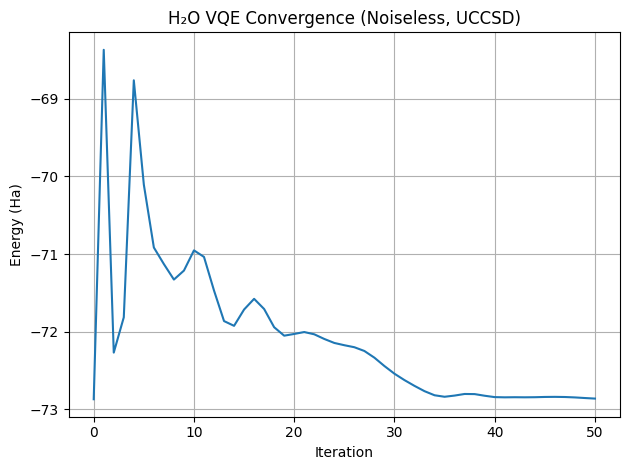

In [6]:
# Adaptive Moment Estimation (Adam) optimizer
opt = get_optimizer("Adam", stepsize=0.2)
energy = [cost_function(params)]

# VQE optimization loop
max_iterations = 50
for _ in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost_function, params)
    energy.append(cost_function(params))

# Plotting VQE convergence
plt.plot(range(len(energy)), energy)
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.title('H₂O VQE Convergence (Noiseless, UCCSD)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{IMG_DIR}/H2O_Adam.png', dpi=300)
plt.show()

In [7]:
num_singles = len(singles)
theta_singles = params[:num_singles]
theta_doubles = params[num_singles:]

print(f"Final single excitation parameters: {theta_singles[0]:.8f}, {theta_singles[1]:.8f}")
print(f"Final double excitation parameters: {theta_doubles[0]:.8f}, {theta_doubles[1]:.8f}")

Final single excitation parameters: -0.00458371, 0.00392305
Final double excitation parameters: 0.06609697, -0.03962196


In [8]:
@qml.qnode(dev)
def ground_state(params):
    excitation_ansatz(
        params,
        wires=range(num_wires),
        hf_state=hf,
        excitations=(singles, doubles),
        excitation_type="both"
    )

    # Return the entire quantum statevector
    return qml.state()

final_state = ground_state(params)

# Find non-zero (or near non-zero) entries
threshold = 1e-2  # Recommended smaller threshold to capture all significant amplitudes
non_zero_indices = np.where(np.abs(final_state) > threshold)[0]
non_zero_amplitudes = final_state[non_zero_indices]

# Build the full ket notation string
ket_terms = []
for idx, amp in zip(non_zero_indices, non_zero_amplitudes):
    binary_state = f"|{idx:0{num_wires}b}⟩"
    amp_str = f"{amp.real:.4f}" if np.isclose(amp.imag, 0, atol=1e-6) else f"({amp.real:.4f} + {amp.imag:.4f}j)"
    ket_terms.append(f"{amp_str}{binary_state}")

# Join all terms into one quantum state expression and print
ket_notation = " + ".join(ket_terms)
print(f"Ground state of H₂O:\n|ψ⟩ = {ket_notation}")

Ground state of H₂O:
|ψ⟩ = -0.0108|11001111110011⟩ + 0.0248|11101111011100⟩ + 0.0199|11110110111100⟩ + -0.0148|11110111101100⟩ + -0.0122|11111001111100⟩ + -0.0251|11111100111100⟩ + 0.0573|11111110110100⟩ + -0.0236|11111111001100⟩ + 0.0160|11111111011000⟩ + 0.9963|11111111110000⟩


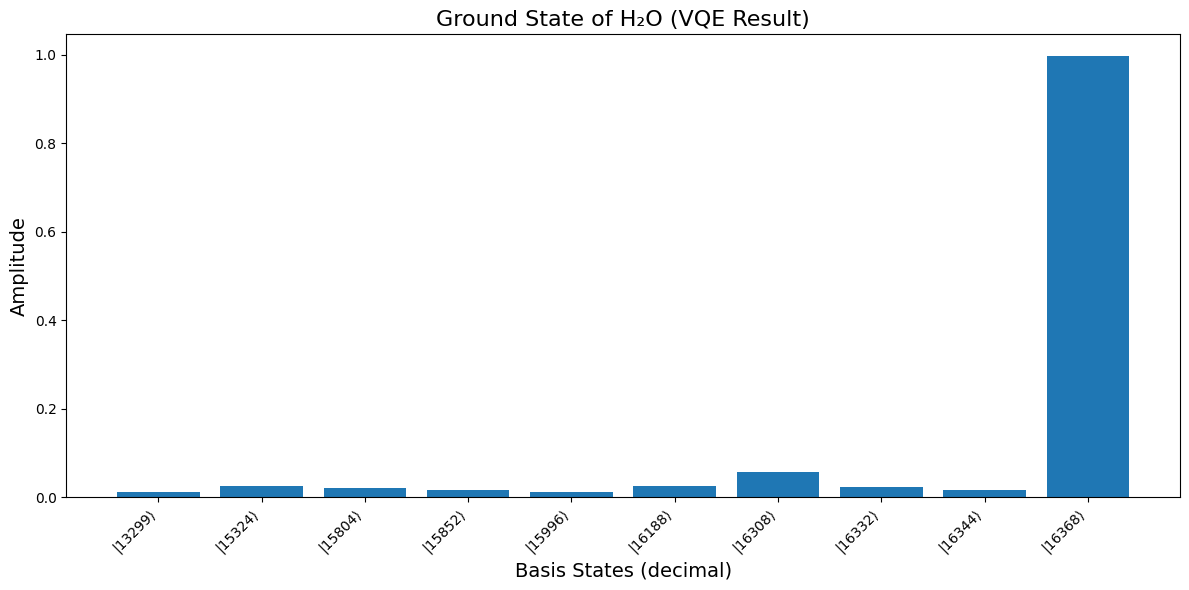

In [10]:
# Prepare labels and amplitudes for the plot (decimal labels for readability)
labels = [f"|{i}⟩" for i in non_zero_indices]
amplitudes = np.abs(non_zero_amplitudes)

plt.figure(figsize=(12, 6))
plt.bar(labels, amplitudes)
plt.xlabel('Basis States (decimal)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Ground State of H₂O (VQE Result)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'{IMG_DIR}/H2O_Ground_State.png', dpi=300)
plt.show()